In [275]:
%load_ext autoreload 
%autoreload 2

%aimport -pandas
%aimport -scipy.stats
%aimport -numpy
%aimport -matplotlib.pyplot


import default_calcs as default
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas
import collateral_waterfall as cw
import prepayment_calcs as pc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
initial_balance = 100e6    # 100 million
net_coupon      = 0.10     # 10%
gross_coupon    = 0.1065   # 10.65%
maturity        = 360      # 30 years => monthly
servicing       = 0.0   # servicing = 25bps

bonds = [
    {'Bond': 'A',
    'Balance': 30e6,
    'Coupon': 0.07},

    {'Bond': 'B',
    'Balance': 40e6,
    'Coupon': 0.09},
    
    {'Bond': 'C',
    'Balance': 30e6,
    'Coupon': 0.10}
]

bonds_with_zbond = [
    {'Bond': 'A',
    'Balance': 30e6,
    'Coupon': 0.07},

    {'Bond': 'B',
    'Balance': 40e6,
    'Coupon': 0.09},
    
    {'Bond': 'Z',
    'Balance': 30e6,
    'Coupon': 0.10,
    'Type': 'accrual'}
]

In [208]:
bonds_with_zbond[0]['Type']

KeyError: 'Type'

In [ ]:
psa_100 = cw.create_waterfall(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=1,
                             servicing=servicing)
psa_175 = cw.create_waterfall(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=1.75,
                             servicing=servicing)
psa_400 = cw.create_waterfall(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=4,
                             servicing=servicing)

In [ ]:
print('PSA\tAverage Life')
print('100%:\t{0:.2f}'.format(weighted_average_life(psa_100)/12))
print('175%:\t{0:.2f}'.format(weighted_average_life(psa_175)/12))
print('400%:\t{0:.2f}'.format(weighted_average_life(psa_400)/12))


In [ ]:
%matplotlib
frames = [psa_100,psa_175,psa_400]

fig, axes = plt.subplots(3,2)
for i in range(3):
    for j in range(2):
        if j == 0:
            axes[i,j].fill_between(frames[i].index-1,
                                  frames[i].beginning_balance)
        else:
            axes[i,j].stackplot(frames[i].index-1, 
                          frames[i].scheduled_principal,
                          frames[i].prepayments,
                          frames[i].net_interest,
                          frames[i].servicing)
            
plt.tight_layout(True)
plt.show()

Initializing...
Creating collateral waterfall...
Producing CMO waterfall...
Merging waterfalls...
Done...
2.39706829539
5.96722695704
12.3993834543
2.55278324432
7.28874812861
17.5116153493
Wall time: 8.33 s


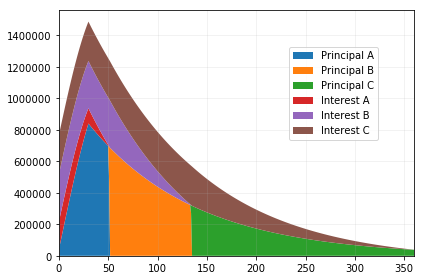

In [278]:
%%time

%matplotlib inline
import xlwings as xw
wb = xw.Book('G:/Programming/Python/zeusRMBS/workbooks/Chapter 6 - CMOs.xlsx')
ChartData = wb.sheets('ChartData')

import CMO_waterfall as cmo

struct = cmo.CMO(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=1.75,
                             servicing=servicing,
                             bonds=bonds)

print(((struct.waterfall.index.values * struct.waterfall['Cashflow_A']).sum() / 
    struct.waterfall['Cashflow_A'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Cashflow_B']).sum() / 
    struct.waterfall['Cashflow_B'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Cashflow_C']).sum() / 
    struct.waterfall['Cashflow_C'].sum()) / 12)


print(((struct.waterfall.index.values * struct.waterfall['Principal_A']).sum() / 
    struct.waterfall['Principal_A'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Principal_B']).sum() / 
    struct.waterfall['Principal_B'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Principal_C']).sum() / 
    struct.waterfall['Principal_C'].sum()) / 12)

ChartData.range('A1').expand().value = ""
ChartData.range('A1').value = struct.waterfall[['Interest_Paid_A',
                                           'Principal_A',
                                           'Interest_Paid_B',
                                           'Principal_B',
                                           'Interest_Paid_C',
                                           'Principal_C',
                                           'remaining_principal',
                                           'remaining_interest']]

wb.sheets('Waterfall').range('A1').value = struct.waterfall

fig, ax = plt.subplots(1,1)
ax = plt.stackplot(struct.waterfall.index.values.tolist(),
                struct.waterfall.Principal_A.values.tolist(),
                struct.waterfall.Principal_B.values.tolist(),
                struct.waterfall.Principal_C.values.tolist(),
                struct.waterfall.Interest_Paid_A.values.tolist(),
                struct.waterfall.Interest_Paid_B.values.tolist(),
                struct.waterfall.Interest_Paid_C.values.tolist())
handles = []
labels = ['Principal A','Principal B','Principal C','Interest A','Interest B','Interest C']
for axis in ax:
    handles.append(axis)
    axis.set_clip_on(True)
    axis.axes.grid(True, alpha=0.2)
    
fig.frameon=False
#fig.tightbbox=True
fig.tight_layout()
fig.legend(handles, labels, loc=(.68,.50), fancybox=True)
plt.axis(xmin=0, xmax=360)

figure = wb.sheets('figure')
figure.pictures.add(fig, name='CMO Watefall', update=True)



Initializing...
Creating collateral waterfall...
Producing CMO waterfall...
Merging waterfalls...
Done...
1.76042230338
3.97752214771
16.3007905667
1.84058078574
4.61657282711
21.7867182099
Wall time: 7.29 s


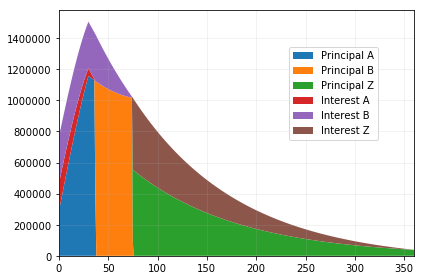

In [289]:

#%matplotlib inline
import xlwings as xw
wb = xw.Book('G:/Programming/Python/zeusRMBS/workbooks/Chapter 6 - CMOs _ accrual bond.xlsx')
ChartData = wb.sheets('ChartData')

import CMO_waterfall as cmo

struct = cmo.CMO(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=1.75,
                             servicing=servicing,
                             bonds=bonds_with_zbond)


print(((struct.waterfall.index.values * struct.waterfall['Principal_A']).sum() / 
    struct.waterfall['Principal_A'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Principal_B']).sum() / 
    struct.waterfall['Principal_B'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Principal_Z']).sum() / 
    struct.waterfall['Principal_Z'].sum()) / 12)

ChartData.range('A1').expand().value = ""
ChartData.range('A1').value = struct.waterfall[['Interest_Paid_A',
                                           'Principal_A',
                                           'Interest_Paid_B',
                                           'Principal_B',
                                           'Interest_Paid_Z',
                                           'Principal_Z',
                                           'remaining_principal',
                                           'remaining_interest']]

wb.sheets('Waterfall').range('A1').value = struct.waterfall

fig, ax = plt.subplots(1,1)
ax = plt.stackplot(struct.waterfall.index.values.tolist(),
                struct.waterfall.Principal_A.values.tolist(),
                struct.waterfall.Principal_B.values.tolist(),
                (struct.waterfall.Principal_Z.values +
                (struct.waterfall.Interest_Due_Z.values - 
                 struct.waterfall.Interest_Paid_Z.values)).tolist(),
                struct.waterfall.Interest_Paid_A.values.tolist(),
                struct.waterfall.Interest_Paid_B.values.tolist(),
                struct.waterfall.Interest_Paid_Z.values.tolist())
handles = []
labels = ['Principal A','Principal B','Principal Z','Interest A','Interest B','Interest Z']
for axis in ax:
    handles.append(axis)
    axis.set_clip_on(True)
    axis.axes.grid(True, alpha=0.2)
    
fig.frameon=False
#fig.tightbbox=True
fig.tight_layout()
fig.legend(handles, labels, loc=(.68,.50), fancybox=True)
plt.axis(xmin=0, xmax=360)

figure = wb.sheets('figure')
figure.pictures.add(fig, name='CMO Watefall', update=True)

